# **Carregando modelo fine tuned de classificação para patologia**

Para servir um modelo na Vertex AI, é preferível ter um formato mais portátil, como um SavedModel, já que a plataforma usa o TensorFlow Serving por baixo dos panos. Neste caso, vamos recarregar o modelo original para convertê-lo.

Para acessar o Hugging Face, use um token: https://huggingface.co/settings/tokens

In [ ]:
from huggingface_hub import HfFolder

HfFolder.save_token("YOUR_TOKEN")

Para carregar o modelo, precisamos da classe EmbeddingLayer usada antes

In [ ]:
import tensorflow as tf

from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model

from huggingface_hub import from_pretrained_keras

@register_keras_serializable()
class EmbeddingLayer(Layer):
  """A custom Keras layer that wraps a pre-trained embedding model for fine-tuning."""

  def __init__(self, model, model_name='google/path-foundation', **kwargs):
    """ Initialize the EmbeddingLayer with a pre-trained model. """
    super().__init__(**kwargs)
    self.embedding_model = model
    self.model_name = model_name


  @tf.function
  def call(self, inputs):
    """ Compute embeddings by passing inputs through the embedding model. """
    return self.embedding_model(inputs)

  def get_config(self):
    """ Return the configuration dictionary of the layer for serialization. """
    config = super().get_config()
    config.update({
        'model_name': self.model_name
    })
    return config

  @classmethod
  def from_config(cls, config):
    """ Instantiate an EmbeddingLayer from a configuration dictionary. """
    model_name = config.pop('model_name')
    embedding_model = from_pretrained_keras(model_name, compile=False)
    return cls(model=embedding_model, model_name=model_name, **config)

Não se esqueça de carregar seu `fine_tuned_model.keras` em um local acessível ao ambiente de execução do notebook.

In [ ]:
model_finetuned = load_model('fine_tuned_model.keras', compile=False)

In [ ]:
model_finetuned.summary()

Model: "path_classifer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (EmbeddingLayer)           │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_output (Dense)        │ (None, 2)                   │             770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

Modelo devidamente recarregado, agora vamos salvá-lo no formato `SavedModel`:

In [ ]:
model_finetuned.export('fine_tuned_model_tf', format='tf_saved_model')

Saved artifact at 'fine_tuned_model_tf.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134344778490960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778490768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778490576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778490384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778490192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778490000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778489808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778489616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778489424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778489232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134344778

##**Vamos testar o modelo no novo formato e comparar com o anterior**

In [ ]:
# Se quiser executar o notebook sem as etapas anteriores:
# import tensorflow as tf

In [ ]:
reloaded_artifact = tf.saved_model.load("fine_tuned_model_tf")

Vamos utilizar uma imagem de testes disponível no Hugging Face:

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


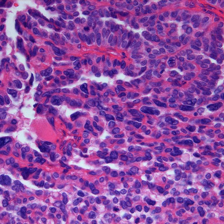

In [ ]:
from PIL import Image as PILImage
from IPython.display import display
from huggingface_hub import hf_hub_download

# Download the test image from Hugging Face Hub
hf_hub_download(repo_id="google/path-foundation", filename='Test.png', local_dir='.')

# Open the image, crop it, convert it to RGB format, and display it.
img = PILImage.open("Test.png").crop((0, 0, 224, 224)).convert('RGB')
display(img)

Converta a imagem em um Tensor e dimensione para [0, 1]:


In [ ]:
import numpy as np

# Convert the image to a Tensor and scale to [0, 1]
tensor = tf.cast(tf.expand_dims(np.array(img), axis=0), tf.float32) / 255.0

In [ ]:
prediction_savedmodel = reloaded_artifact.serve(tensor)
prediction_savedmodel

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.947213  , 0.05278708]], dtype=float32)>

In [ ]:
prediction_keras = model_finetuned(tensor).numpy()
prediction_keras

array([[0.947213  , 0.05278708]], dtype=float32)

Mesmos resultados? Então tudo certo!

Para referência: **array([[0.947213  , 0.05278708]], dtype=float32)**